# Recurrent Neural Networks (RNN)

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

## Create Dictionary

In [2]:
text = ['hey how are you', 'good i am fine', 'have a nice day']

# join all the sentences together and extract the unique characters from the combined sentences
chars = set(' '.join(text))

# creating a dictionary that maps integers to the characters
int2char = dict(enumerate(chars))

# creating another dictionary that maps characters to integers
char2int = { char: idx for idx, char in int2char.items() }

## Pad Inputs

In [3]:
# finding the length of the longest string in our data
len_max = len(max(text, key=len))

In [4]:
# a simple loop that loops through the list of sentences and adds a ' ' whitespace
# until the length of the sentence mathces the length of the longest sentence
for i in range(len(text)):
    while len(text[i]) < len_max:
        text[i] += ' '

## Create inputs-outputs in sequences

In [5]:
# creating lists that will hold our input and target sequences
seq_input = []
seq_target = []

for i in range(len(text)):
    # remove last character for input sequence
    seq_input.append(text[i][:-1])
    
    # remove first character for target sequence
    seq_target.append(text[i][1:])
    print("{}. Input Sequence: {} | Target Sequence: {}".format(i+1, seq_input[i], seq_target[i]))

1. Input Sequence: hey how are yo | Target Sequence: ey how are you
2. Input Sequence: good i am fine | Target Sequence: ood i am fine 
3. Input Sequence: have a nice da | Target Sequence: ave a nice day


## Convert Inputs (char2int)

In [6]:
for i in range(len(text)):
    seq_input[i] = [char2int[character] for character in seq_input[i]]
    seq_target[i] = [char2int[character] for character in seq_target[i]]

## One-hot-encode Inputs

In [7]:
dict_size = len(char2int)
seq_len = len_max - 1
batch_size = len(text)

def one_hot_encode(sequence, dict_size, seq_len, batch_size):
    # creating a multi-dimensional array of zeros with the desired output shape
    features = np.zeros((batch_size, seq_len, dict_size), dtype=np.float32)
    
    # replacing the 0 at the relevant character index with a 1 to represent that character
    for i in range(batch_size):
        for u in range(seq_len):
            features[i, u, sequence[i][u]] = 1
    return features

In [8]:
seq_input = one_hot_encode(seq_input, dict_size, seq_len, batch_size)

## Convert To Tensors

In [9]:
seq_input = torch.from_numpy(seq_input)
seq_target = torch.Tensor(seq_target)

## Set Configs

In [10]:
N_EPOCHS = 100
LR = 0.01

In [11]:
is_cuda = torch.cuda.is_available()

if is_cuda: device = torch.device('cuda')
else: device = torch.device('cpu')

## Build [RNN](https://arxiv.org/pdf/1808.03314.pdf) Network

In [12]:
class RNN(nn.Module):
    
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(RNN, self).__init__()
        
        # defining some parameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        # defining the layers (rnn for one-to-one or many-to-one)
        self.rnn_cell = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)
        self.fc_layer = nn.Linear(hidden_dim, output_size)
        
    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
        return hidden
    
    def forward(self, x):
        
        batch_size = x.size(0)
        
        h = self.init_hidden(batch_size)
        x, h = self.rnn_cell(x, h)
        x = x.contiguous().view(-1, self.hidden_dim) # reshape the outputs
        output = self.fc_layer(x)
        
        return output, h

#### Initialize RNN Network with hyper-parameters

In [13]:
rnn = RNN(input_size=dict_size, output_size=dict_size, hidden_dim=12, n_layers=1)
rnn.to(device)

RNN(
  (rnn_cell): RNN(17, 12, batch_first=True)
  (fc_layer): Linear(in_features=12, out_features=17, bias=True)
)

## Set Loss Function

In [14]:
CELoss = nn.CrossEntropyLoss()

## Set Optimizers

In [15]:
optimizer = torch.optim.Adam(rnn.parameters(), lr=LR)

## Train RNN Network

In [16]:
train_loss_history = []
for epoch in range(N_EPOCHS):
    
    optimizer.zero_grad()
    seq_input.to(device)
    output, hidden = rnn(seq_input)
    loss = CELoss(output, seq_target.view(-1).long())
    
    loss.backward()
    optimizer.step()

    train_loss = loss.item()
    train_loss_history.append(train_loss)
    
    if epoch%9 == 0:
        print('Epoch: {}/{}.................'.format(epoch+1, N_EPOCHS), end=' ')
        print('Loss: {:.4f}'.format(train_loss))

Epoch: 1/100................. Loss: 2.7718
Epoch: 10/100................. Loss: 2.3677
Epoch: 19/100................. Loss: 2.0972
Epoch: 28/100................. Loss: 1.7607
Epoch: 37/100................. Loss: 1.4088
Epoch: 46/100................. Loss: 1.0837
Epoch: 55/100................. Loss: 0.7983
Epoch: 64/100................. Loss: 0.5720
Epoch: 73/100................. Loss: 0.4133
Epoch: 82/100................. Loss: 0.3092
Epoch: 91/100................. Loss: 0.2402
Epoch: 100/100................. Loss: 0.1918


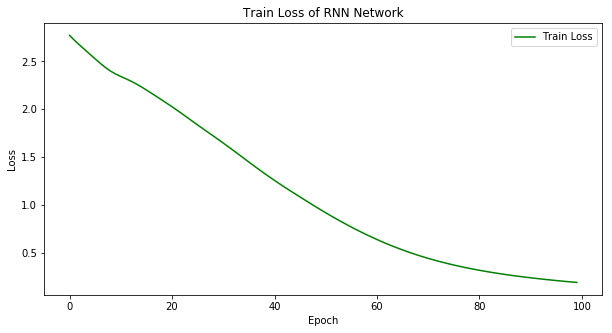

In [17]:
plt.figure(figsize=(10,5))
plt.title("Train Loss of RNN Network")
plt.plot(train_loss_history, label="Train Loss", color="green")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

if not os.path.exists('./images/'): os.makedirs('./images/')
plt.savefig('./images/RNN_final_train_loss.png')
plt.show()

## Test RNN Network

In [18]:
def predict(model, character):
    # one-hot-encode the input to fit into the model
    character = np.array([[char2int[char] for char in character]])
    character = one_hot_encode(character, dict_size, character.shape[1], 1)
    character = torch.from_numpy(character)
    character.to(device)
    
    output, hidden = rnn(character)
    prob = nn.functional.softmax(output[-1], dim=0).data
    char_idx = torch.max(prob, dim=0)[1].item()
    
    return int2char[char_idx], hidden

In [19]:
def reproduce_sentence(model, output_len, start='hey'):
    rnn.eval()
    start = start.lower()
    
    chars = [ch for ch in start]
    size = output_len - len(chars)
    for ii in range(size):
        char, hidden = predict(rnn, chars)
        chars.append(char)
        
    return ''.join(chars)

## Let's Play!

In [20]:
reproduce_sentence(rnn, len_max, 'hey')

'hey how are you'

In [21]:
reproduce_sentence(rnn, len_max, 'good')

'good i am fine '

In [22]:
reproduce_sentence(rnn, len_max, 'have')

'have a nice day'

---